In [52]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Name : LIChI
# Copyright (C) Inria,  Sébastien Herbreteau, Charles Kervrann, All Rights Reserved, 2022, v1.0.

import torch
from torchvision.io import read_image, write_png
from lichi import LIChI
import argparse
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--sigma", type=float, dest="sigma",
                    help="Standard deviation of the noise (noise level). Should be between 0 and 50.", default=15)
parser.add_argument("--in", type=str, dest="path_in",
                    help="Path to the image to denoise (PNG or JPEG).", default="./test_images/cameraman.png")
parser.add_argument("--out", type=str, dest="path_out",
                    help="Path to save the denoised image.", default="./denoised.png")
parser.add_argument("--add_noise", action='store_true',
                    help="Add artificial Gaussian noise to the image.", default=True)

# To avoid conflicts with Jupyter's arguments, pass an empty list to parse_args()
args = parser.parse_args(args=[])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Reading
img = read_image(args.path_in)[None, :, :, :].float().to(device)
img_noisy = img + args.sigma * torch.randn_like(img) if args.add_noise else img

In [4]:
# Denoising
model = LIChI()
t = time.time()
if args.sigma <= 10:
	den = model(img_noisy, sigma=args.sigma, constraints='affine', method='n2n', p1=9, p2=6, k1=16, k2=64, w=65, s=3, M=6)
elif args.sigma <= 30:
	den = model(img_noisy, sigma=args.sigma, constraints='affine', method='n2n', p1=11, p2=6, k1=16, k2=64, w=65, s=3, M=9)
else:
	den = model(img_noisy, sigma=args.sigma, constraints='affine', method='n2n', p1=13, p2=6, k1=16, k2=64, w=65, s=3, M=11)
print("Time elapsed:", round(time.time() - t, 3), "seconds")
den = den.clip(0, 255)


Time elapsed: 14.847 seconds


In [5]:
## Low rank denoising, keep the first 99% energy based on singular value

img_lr = img_noisy
img_lr = torch.squeeze(img_lr)

U, S, Vh = torch.linalg.svd(img_lr, full_matrices=False)

threshold = 0.99
energy_total = torch.sum(S**2)
energy_cumulative = torch.cumsum(S**2, dim=0)
energy_threshold = threshold * energy_total
k = torch.searchsorted(energy_cumulative, energy_threshold).item()+1
print("Keep the first {} singular values".format(k))

U_k = U[:, :k]
S_k = torch.diag(S[:k])
Vh_k = Vh[:k, :]

img_lr_output = U_k @ S_k @ Vh_k
img_lr_output = img_lr_output.clip(0, 255)

Keep the first 55 singular values


In [101]:
img_test = torch.squeeze(img)
torch.linalg.norm(img_lr_output - img_test), torch.linalg.norm(den - img_test), torch.linalg.norm(img_llr - img_test)

(tensor(3156.0972), tensor(1605.5424), tensor(2751.5618))

In [100]:
psnr = 10*torch.log10(255**2 / torch.mean((img_lr_output - img)**2))
print("PSNR:", round(float(psnr), 2), "dB")

psnr = 10*torch.log10(255**2 / torch.mean((img_llr - img)**2))
print("PSNR:", round(float(psnr), 2), "dB")

psnr = 10*torch.log10(255**2 / torch.mean((den - img)**2))
print("PSNR:", round(float(psnr), 2), "dB")

PSNR: 26.31 dB
PSNR: 27.5 dB
PSNR: 32.18 dB


In [98]:

im = torch.squeeze(img_noisy)
block_size = [8, 8]
img_size = torch.squeeze(img).shape

def im2row(im, img_size, block_size):
    H, W = img_size
    block_h, block_w = block_size

    patch_h = H - block_h + 1
    patch_w = W - block_w + 1
    patch_num = patch_h * patch_w
    block_length = block_h * block_w
    result = torch.zeros((block_length, patch_num))

    patch_idx = 0
    for y in range(patch_w):
        for x in range(patch_h):
            patch = im[x:x+block_h, y:y+block_w]
            result[:, patch_idx] = patch.reshape(-1)
            patch_idx += 1
    return result


def row2im(patches, img_size, block_size):
    H, W = img_size
    block_h, block_w = block_size
    result = torch.zeros((H, W))
    weight = torch.zeros((H, W))

    patch_idx = 0
    for y in range(W-block_w+1):
        for x in range(H-block_h+1):
            patch = patches[:, patch_idx]
            result[x:x+block_h, y:y+block_w] += patch.reshape(8, 8)
            weight[x:x+block_h, y:y+block_w] += 1
            patch_idx += 1
    
    # weight = torch.clamp(weight, min=1e-6)
    result /= weight
    return result



patches = im2row(im, img_size, block_size)

U, S, Vh = torch.linalg.svd(patches, full_matrices=False)
k = 20

U_k = U[:, :k]
S_k = torch.diag(S[:k])
Vh_k = Vh[:k, :]

patch_lr = U_k @ S_k @ Vh_k

# patch_lr = torch.squeeze(patch_lr)
img_llr = row2im(patch_lr, img_size, block_size)
img_llr = img_llr.clip(0, 255)


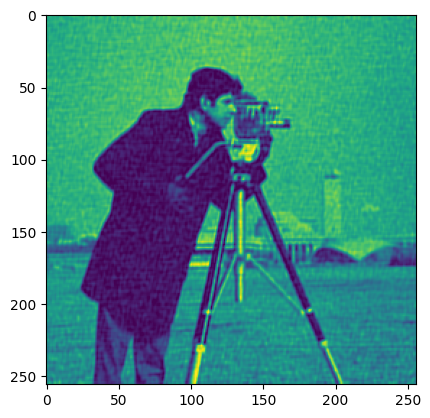

In [93]:
plt.imshow(img_llr)

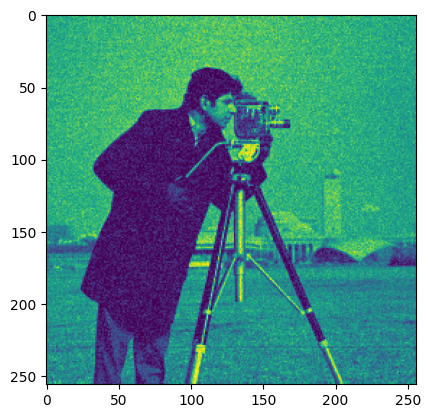

In [76]:
plt.imshow(img_llr)

In [72]:
patches.shape

torch.Size([8, 8, 62001])

In [89]:
U.shape

torch.Size([64, 64])